# BG-NBD ve Gamma-Gamma ile CLTV Prediction

1. Verinin Hazırlanması (Data Preperation)
2. BG-NBD Modeli ile Expected Number of Transaction
3. Gamma-Gamma Modeli ile Expected Average Profit
4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
5. CLTV'ye Göre Segmentlerin Oluşturulması
6. Çalışmanın fonksiyonlaştırılması

In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

In [4]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [6]:
def outlier_thresholds(df, veriable):
    quartile1 = df[veriable].quantile(0.01)
    quartile3 = df[veriable].quantile(0.99)

    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    return round(low_limit), round(up_limit)

In [7]:
def replace_with_thresholds(df, veriable):
    low_limit, up_limit = outlier_thresholds(df, veriable)
    df.loc[(df[veriable] < low_limit), veriable] = low_limit
    df.loc[(df[veriable] > up_limit), veriable] = up_limit

In [8]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [11]:
##Notebook Mühendisliği##
# replace_with_thresholds(df, "order_num_total_ever_online")
# replace_with_thresholds(df, "order_num_total_ever_offline")
# replace_with_thresholds(df, "customer_value_total_ever_offline")
# replace_with_thresholds(df, "customer_value_total_ever_online")

In [12]:
# Aykırı değerleri baskılıyoruz.
num_columns = [col for col in df.columns if "num" in col or "value" in col]
for col in num_columns:
    replace_with_thresholds(df, col)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


In [14]:
df["TotalEver"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["TotalEverValue"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

In [15]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,TotalEver,TotalEverValue
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [16]:
# Tarih olan ama object tipte tanımlanmış değişkenler tarih formatına dönüştürülüyor.
date_columns = [col for col in df.columns if "date" in col]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [18]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [19]:
today_date = dt.datetime(2021, 6, 1)

In [20]:
cltv_df = pd.DataFrame()

1. recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
2. T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
3. frequency: tekrar eden toplam satın alma sayısı (frequency>1)
4. monetary: satın alma başına ortalama kazanç

In [21]:
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days
cltv_df["T_weekly"] = (today_date - df["first_order_date"]).dt.days
cltv_df["frequency"] = df["TotalEver"]
cltv_df["monetary_cltv_weekly"] = df["TotalEverValue"]


In [22]:
cltv_df["monetary_cltv_weekly"] = cltv_df["monetary_cltv_weekly"] / cltv_df["frequency"]

In [23]:
cltv_df = cltv_df[cltv_df["frequency"] > 1]

In [24]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.0000,666.8445,522.1261,0.0000,353.0000,536.0000,766.0000,3034.0000
T_weekly,19945.0000,801.3028,523.3969,5.0000,517.0000,651.0000,836.0000,3060.0000
frequency,19945.0000,4.9781,4.1209,2.0000,3.0000,4.0000,6.0000,57.0000
monetary_cltv_weekly,19945.0000,152.0990,73.5241,22.4900,103.6533,136.9062,182.4500,1401.8000


In [25]:
cltv_df["recency_cltv_weekly"] = cltv_df["recency_cltv_weekly"] / 7
cltv_df["T_weekly"] = cltv_df["T_weekly"] / 7

In [26]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.0000,95.2635,74.5894,0.0000,50.4286,76.5714,109.4286,433.4286
T_weekly,19945.0000,114.4718,74.7710,0.7143,73.8571,93.0000,119.4286,437.1429
frequency,19945.0000,4.9781,4.1209,2.0000,3.0000,4.0000,6.0000,57.0000
monetary_cltv_weekly,19945.0000,152.0990,73.5241,22.4900,103.6533,136.9062,182.4500,1401.8000


BG-NBD Modelinin Kurulması

In [27]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [28]:
bgf.fit(cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [29]:
cltv_df["exp_sales_3_month"] = bgf.predict(12, cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])

In [30]:
cltv_df["exp_sales_6_month"] = bgf.predict(24, cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])

In [31]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921


Tahmin Sonuçlarının Değerlendirilmesi

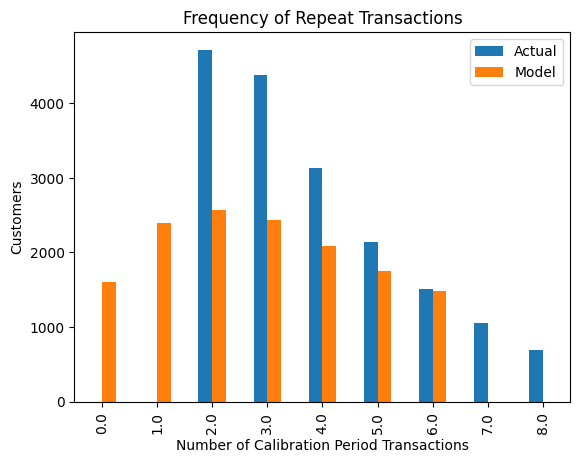

In [32]:
plot_period_transactions(bgf)
plt.show()

# GAMMA-GAMMA Modelinin Kurulması

In [33]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [34]:
ggf.fit(cltv_df["frequency"],cltv_df["monetary_cltv_weekly"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [35]:
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(
    cltv_df["frequency"],
    cltv_df["monetary_cltv_weekly"])

In [36]:
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251
...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.1429,88.4286,3.0000,133.9867,0.4858,0.9716,141.3604
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.2857,65.2857,2.0000,195.2350,0.4804,0.9609,210.7224
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.7143,89.8571,3.0000,210.9800,0.4816,0.9632,221.7752
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.4286,113.8571,6.0000,168.2950,0.6102,1.2204,172.6475


##  BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

In [37]:
cltv = ggf.customer_lifetime_value(
    bgf,
    cltv_df["frequency"],
    cltv_df["recency_cltv_weekly"],
    cltv_df["T_weekly"],
    cltv_df["monetary_cltv_weekly"],
    time = 6, # 6 aylık
    freq = "W", # T'nin frekans bilgileri
    discount_rate= 0.01
)

In [38]:
cltv

0       395.7332
1       199.4307
2       170.2242
3        98.9455
4        95.0117
          ...   
19940   144.1017
19941   212.4408
19942   224.1308
19943   221.0789
19944   121.2163
Name: clv, Length: 19945, dtype: float64

In [39]:
cltv = cltv.reset_index()
cltv.head()

,index,clv
0,0,395.7332
1,1,199.4307
2,2,170.2242
3,3,98.9455
4,4,95.0117


In [40]:
cltv_df["cltv"] = cltv["clv"]

In [41]:
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117
...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.1429,88.4286,3.0000,133.9867,0.4858,0.9716,141.3604,144.1017
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.2857,65.2857,2.0000,195.2350,0.4804,0.9609,210.7224,212.4408
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.7143,89.8571,3.0000,210.9800,0.4816,0.9632,221.7752,224.1308
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.4286,113.8571,6.0000,168.2950,0.6102,1.2204,172.6475,221.0789


In [42]:
cltv_df.sort_values(by="cltv", ascending=False).head(10)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.8571,7.8571,4.0000,1401.8000,1.0944,2.1888,1449.0605,3327.7770
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.1429,13.1429,11.0000,758.0855,1.9701,3.9402,767.3606,3172.3944
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.7143,101.0000,7.0000,1106.4671,0.7222,1.4445,1127.6115,1708.9821
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.2857,74.5714,16.0000,501.8737,1.5653,3.1306,506.1667,1662.6135
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.7143,67.2857,52.0000,166.2246,4.6561,9.3123,166.7123,1628.8874
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.4286,34.4286,8.0000,601.2262,1.2655,2.5309,611.4926,1623.8127
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.2857,9.4286,2.0000,862.6900,0.7939,1.5878,923.6800,1538.8559
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.7143,13.0000,17.0000,259.8653,2.7807,5.5614,262.0729,1529.2280
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.5714,58.7143,31.0000,228.5300,3.0838,6.1676,229.6069,1485.8192
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.8571,15.5714,3.0000,743.5867,0.8716,1.7431,778.0504,1422.9997


# CLTV'ye Göre Segmentlerin Oluşturulması

In [43]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"],4,labels = ["D","C","B","A"])

In [44]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D


In [45]:
cltv_df.groupby("segment").agg({"count", "mean","sum"})

recency_cltv_weekly                   T_weekly                   frequency                  monetary_cltv_weekly                    exp_sales_3_month                 exp_sales_6_month                 exp_average_value                        cltv                   
                       mean         sum count     mean         sum count      mean        sum count                 mean          sum count              mean       sum count              mean       sum count              mean          sum count     mean          sum count
segment                                                                                                                                                                                                                                                                         
D                  139.0002 693193.8571  4987 162.1832 808807.7143  4987    3.7688 18795.0000  4987              93.1516  464547.0459  4987            0.4089 2039.1639  4987            0.8178 4078.3277  4987           98.6911  492172.4415  4987  80.3405  400657.9551  4987
C                   92.6295 461850.8571  4986 112.8183 562512.1429  4986    4.4047 21962.0000  4986             125.7885  627181.6473  4986            0.5254 2619.8846  4986            1.0509 5239.7692  4986          132.2506  659401.4525  4986 138.3115  689621.1777  4986
B                   81.9884 408794.0000  4986 100.3265 500228.0000  4986    5.0927 25392.0000  4986             160.6366  800933.9587  4986            0.6011 2997.1097  4986            1.2022 5994.2195  4986          168.0006  837650.8816  4986 199.5328  994870.7838  4986
A                   67.4271 336191.7143  4986  82.5497 411592.8571  4986    6.6466 33140.0000  4986             228.8311 1140952.0746  4986            0.7730 3854.3130  4986            1.5461 7708.6260  4986          238.0240 1186787.6390  4986 362.3155 1806505.0889  4986

In [46]:
def create_cltv_p(df,today_date):
    #Boş değerler veri setinden çıkarılıyor.
    df.dropna(inplace=True)

    #Veri setindeki tüm sayısal değişkenler için alt ve üst sınırlar belirleniyor.
    num_columns = [col for col in df.columns if "num" in col or "value" in col]
    for col in num_columns:
        replace_with_thresholds(df, col)
    
    #Veri setindeki toplam sipariş sayısı ve toplam sipariş değeri değişkenleri oluşturuluyor.
    df["TotalEver"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
    df["TotalEverValue"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

    #Veri setindeki tüm tarih değişkenleri datetime formatına çevrilir.
    date_columns = [col for col in df.columns if "date" in col]
    df[date_columns] = df[date_columns].apply(pd.to_datetime)

    #CLTV için gerekli df oluşturuluyor.
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = df["master_id"]
    cltv_df["recency_cltv_weekly"] = (df["last_order_date"] - df["first_order_date"]).dt.days / 7
    cltv_df["T_weekly"] = (today_date - df["first_order_date"]).dt.days / 7
    cltv_df["frequency"] = df["TotalEver"]
    cltv_df = cltv_df[cltv_df["frequency"] > 1]
    cltv_df["monetary_cltv_weekly"] = df["TotalEverValue"] / cltv_df["frequency"]

    #BG/NBD modeli kuruluyor.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])
    cltv_df["exp_sales_3_month"] = bgf.predict(12, cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])
    cltv_df["exp_sales_6_month"] = bgf.predict(24, cltv_df["frequency"], cltv_df["recency_cltv_weekly"], cltv_df["T_weekly"])

    #Gama-Gama modeli kuruluyor.
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df["frequency"],cltv_df["monetary_cltv_weekly"])
    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(
    cltv_df["frequency"],
    cltv_df["monetary_cltv_weekly"])

    #CLTV değeri hesaplanıyor.
    cltv = ggf.customer_lifetime_value(
    bgf,
    cltv_df["frequency"],
    cltv_df["recency_cltv_weekly"],
    cltv_df["T_weekly"],
    cltv_df["monetary_cltv_weekly"],
    time = 6, # 6 aylık
    freq = "W", # T'nin frekans bilgileri (Weekly)
    discount_rate= 0.01
    )
    cltv = cltv.reset_index()
    cltv_df["cltv"] = cltv["clv"]

    #Segmentler oluşturuluyor.
    cltv_df["segment"] = pd.qcut(cltv_df["cltv"],4,labels = ["D","C","B","A"])

    return cltv_df


In [47]:
new_cltv = create_cltv_p(df_, today_date)

In [48]:
new_cltv.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_weekly,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.5714,5.0000,187.8740,0.9739,1.9479,193.6327,395.7332,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,224.8571,21.0000,95.8833,0.9832,1.9663,96.6650,199.4307,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,78.8571,5.0000,117.0640,0.6706,1.3412,120.9676,170.2242,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,20.8571,2.0000,60.9850,0.7004,1.4008,67.3201,98.9455,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.4286,2.0000,104.9900,0.3960,0.7921,114.3251,95.0117,D
